# <center> <h3> The code to generate Figures 4-7 </h3> </center>
## <center> Ning Xu</center>


This file is compiled and generated automatically by Jupyter notebook. In this file, we demonstrate repeated simulations on the upper bound. The code in this file is almost the same as the supplementray file "CVbounds_markdown". In this file, given each value of $(n/K)/p$, we repeat the computation of the 90% upper bound on different i.i.d. samples 20 times. The results are attached below the code.

## Step 1: define all the functions as in the file "CVbounds"

For more information, please see the file "CVbounds" or the simulation section in the paper.

## Jupyter notebook returns the results (figures, outcomes, prints) below the code box

In [1]:
# clear the memory before each compilation
%reset -f 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [2]:
#generate data for the regression

def data_gen(sample_size, n_dim, n_info, cov_noise):
    
    a = np.ones((n_dim, n_dim)) * 0.5; A = np.eye(n_dim)*0.5

    cov_x = a + A; mean_x = np.zeros(n_dim)

    X = np.random.multivariate_normal(mean_x, cov_x, sample_size)

    beta_info = np.arange(3,n_info + 3)
    beta = np.concatenate((beta_info, np.zeros(n_dim-n_info)), axis = 0)

    noise = np.random.normal(0, cov_noise, sample_size); 
    noise.shape = (sample_size, 1); beta.shape = (1, n_dim) 

    Y = np.inner(X,beta) + noise 

    return X, Y

In [3]:
# to estimate the Rademacher complexity, we generate rademacher variables 

def rade_generator( sample_size ):
    
    ans = np.random.randint(2, size=sample_size)
    rade = (ans - 0.5) * 2
    
    return rade


In [4]:
# estimating the empirical rademacher complexity

def emp_rc(sample_size, n_iter, reg, n_dim, n_info, cov_noise):
    
    X, Y = data_gen(sample_size, n_dim, n_info, cov_noise)
    
    cond = np.zeros([n_iter,1])
    
    for i in range(n_iter):
        
        rade = rade_generator(sample_size)
        reg.fit(X, rade) ; rade_pre = reg.predict(X)
        rade_pre = np.matrix(rade_pre); cond[i,0] = np.dot(rade_pre, rade)/ sample_size
    
    emp_rc = np.mean(cond) * 2 
   
    return emp_rc, cond


In [5]:
# estimating the rademacher complexity

def est_rc(sample_size, n_iter, reg, n_dim, n_info, cov_noise):
      
    cond_rc = np.zeros([n_iter])
    
    for i in range(n_iter):
        
        emp_rc_in, _ = emp_rc(sample_size, n_iter, reg, n_dim, n_info, cov_noise)

        cond_rc[i] = emp_rc_in

    est_rc = np.mean(cond_rc)
    
    return est_rc, cond_rc


In [6]:
# establishing the upper bound for classifiers

def rc_bound(n, M, varpi, K, rc_1, rc_2, ave_in_sample_error):
    
    ub = ave_in_sample_error + rc_1 + rc_2 + 2 * M * np.sqrt( np.log( 1 / varpi ) / ( n / K ) )
    
    return ub  


In [7]:
# compute the mean square error of the estimator

def costs(X_train, Y_train, clf):
    
    Y_pred_train = clf.predict(X_train); Y_pred_train.shape = Y_train.shape
    loss_train = mean_squared_error(Y_train, Y_pred_train)
    
    res = np.var(Y_train - Y_pred_train)
    
    return loss_train, res


In [8]:
# the function to estimate the upper bounds for the lasso

def error_bounds(X_train_1, Y_train_1, X_train_2, Y_train_2, 
              test_size, varpi, n_iter, n_val, n_dim, n_info, cov_noise, start, end, step):
    
    ##set the placeholders 
    alpha = np.arange(start, end, step)          # the seq of penalty parameters
    error_matrix = np.zeros((n_val, len(alpha))) # the n_val average test errors for each model
    upper_array  = np.zeros(len(alpha))          # the seq of 90 percentiles for all models 
    train_array  = np.zeros(len(alpha))          # the seq of average trainig errors for all models
    test_array   = np.zeros(len(alpha))          # the seq of CV-errors for all models
    perc_array   = np.zeros(len(alpha))
    
    for l in range(len(alpha)):
        
        #given the value of alpha
        
        #training classifiers
        clf  = Lasso(alpha = alpha[l])
        clf1 = Lasso(alpha = alpha[l]); clf1.fit(X_train_1, Y_train_1)
        clf2 = Lasso(alpha = alpha[l]); clf2.fit(X_train_2, Y_train_2)
        clf3 = Lasso(alpha = alpha[l]); clf2.fit(X_train_2, Y_train_2)
    
        #compute training errors
        loss_train_1, res_var_1 = costs(X_train_1, Y_train_1, clf1)
        loss_train_2, res_var_2 = costs(X_train_2, Y_train_2, clf2)
        train_array[l] = (loss_train_1 + loss_train_2)/2
        
        #compute test errors
        loss_test_1, res_var_3 = costs(X_train_2, Y_train_2, clf1)
        loss_test_2, res_var_4 = costs(X_train_1, Y_train_1, clf2)
        test_array[l] = (loss_test_1 + loss_test_2)/2
        
        res_var = max(res_var_3, res_var_4) ; M = res_var * 1.4
        

        #container of the validation errors
        error_val = np.zeros(n_val); 

        #the loop to compute the out-of-sample errors
        for i in range(n_val):

            X_val_1, Y_val_1 = data_gen(test_size, n_dim, n_info, cov_noise)
            X_val_2, Y_val_2 = data_gen(test_size, n_dim, n_info, cov_noise)

            Y_pred_val_1 = clf1.predict(X_val_1) ; loss_test_val_1 = mean_squared_error(Y_val_1 , Y_pred_val_1)
            Y_pred_val_2 = clf2.predict(X_val_2) ; loss_test_val_2 = mean_squared_error(Y_val_2 , Y_pred_val_2)

            error_val[i] = (loss_test_val_1 + loss_test_val_2)/2
        
        error_matrix[:,l] = error_val
        
        sorted_error = np.sort(error_val); perc_array[l] = sorted_error[-1*round(n_val*0.1)]

        # estimating the RC_test and RC_train
        est_rc_train, cond_rc_SVC_train = est_rc(test_size, n_iter, clf, n_dim, n_info, cov_noise)
        est_rc_test, cond_rc_SVC_test = est_rc(test_size, n_iter, clf, n_dim, n_info, cov_noise)

        #establish the upper bounds
        upper_array[l] = rc_bound( 2 * test_size, M, varpi, K, est_rc_train, est_rc_test, train_array[l])
        
        print("Model", int(l+1), " computed out of ", len(alpha))
        
    lambda_cv_ind  = np.argmin(test_array)
    lambda_cub_ind = np.argmin(upper_array)
    
    lambda_cv  = 1 + lambda_cv_ind  * 0.5
    lambda_cub = 1 + lambda_cub_ind * 0.5        
    
    return error_matrix, upper_array, train_array, test_array, perc_array, lambda_cv, lambda_cub

In [9]:
# the function to plot the average training error, average test error and others

def error_plot_100(alpha, error_matrix, upper_array, train_array, test_array, perc_array,name):
    
    #set the tick of the x axis
    index_plot = np.arange(1, len(alpha)+1); #my_xticks = list(map(str,alpha))
    my_xticks = ['0.1', '0.15', '0.2', '0.25', '0.3', '0.35', '0.4', '0.45']
    
    #set the figure
    f = plt.figure()
    
    #multiple boxplot
    plt.boxplot(error_matrix, widths = 0.25)

    #plot the average training error, average test error, 90% percentile and 90% upper bound
    plt.plot(index_plot, upper_array, color = 'g', label='at-least 90% upper bound')
    plt.plot(index_plot, train_array, color = 'b', label='the average training error')
    plt.plot(index_plot, test_array,  color = 'r', label='the CV-error')
    plt.plot(index_plot, perc_array,  color = 'k', label='90% percentile')

    #set the legend, label, grid and tick
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., shadow=True)
    frame = legend.get_frame()

    plt.xticks(index_plot, my_xticks)
    plt.grid(axis='y', linestyle='-')
    plt.ylim((0.5,3))
    plt.xlabel('value of $\lambda$')
    plt.ylabel('value of the error')

    plt.show()
    
    # save the plot
    # f.savefig(name, bbox_inches='tight')

In [10]:
# the function to plot the average training error, average test error and others

def error_plot_200(alpha, error_matrix, upper_array, train_array, test_array, perc_array,name):
    
    #set the tick of the x axis
    index_plot = np.arange(1, len(alpha)+1); #my_xticks = list(map(str,alpha))
    my_xticks = ['0.1', '0.15', '0.2', '0.25', '0.3', '0.35', '0.4', '0.45']
    
    #set the figure
    f = plt.figure()
    
    #multiple boxplot
    plt.boxplot(error_matrix, widths = 0.25)

    #plot the average training error, average test error, 90% percentile and 90% upper bound
    plt.plot(index_plot, upper_array, color = 'g', label='at-least 90% upper bound')
    plt.plot(index_plot, train_array, color = 'b', label='the average training error')
    plt.plot(index_plot, test_array,  color = 'r', label='the CV-error')
    plt.plot(index_plot, perc_array,  color = 'k', label='90% percentile')

    #set the legend, label, grid and tick
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., shadow=True)
    frame = legend.get_frame()

    plt.xticks(index_plot, my_xticks)
    plt.grid(axis='y', linestyle='-')
    plt.ylim((0.5,2.2))
    plt.xlabel('value of $\lambda$')
    plt.ylabel('value of the error')

    plt.show()
    
    # save the plot
    # f.savefig(name, bbox_inches='tight')

In [11]:
# the function to plot the average training error, average test error and others

def error_plot_50(alpha, error_matrix, upper_array, train_array, test_array, perc_array,name):
    
    #set the tick of the x axis
    index_plot = np.arange(1, len(alpha)+1); #my_xticks = list(map(str,alpha))
    my_xticks = ['0.1', '0.15', '0.2', '0.25', '0.3', '0.35', '0.4', '0.45']
    
    #set the figure
    f = plt.figure()
    
    #multiple boxplot
    plt.boxplot(error_matrix, widths = 0.25)

    #plot the average training error, average test error, 90% percentile and 90% upper bound
    plt.plot(index_plot, upper_array, color = 'g', label='at-least 90% upper bound')
    plt.plot(index_plot, train_array, color = 'b', label='the average training error')
    plt.plot(index_plot, test_array,  color = 'r', label='the CV-error')
    plt.plot(index_plot, perc_array,  color = 'k', label='90% percentile')

    #set the legend, label, grid and tick
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., shadow=True)
    frame = legend.get_frame()

    plt.xticks(index_plot, my_xticks)
    plt.grid(axis='y', linestyle='-')
    plt.ylim((0, 5))
    plt.xlabel('value of $\lambda$')
    plt.ylabel('value of the error')

    plt.show()
    
    # save the plot
    # f.savefig(name, bbox_inches='tight')

## Step 2: repeated simulation of the upper bounds for $n = 200$.

We repeat the $n=200$ simulation 20 times using different random seeds.

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


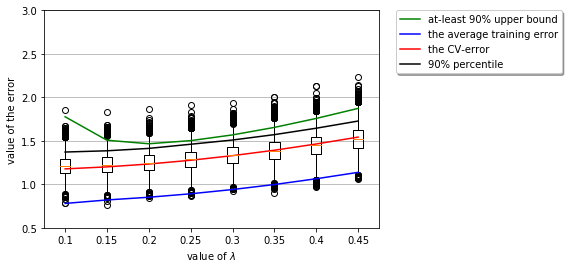

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


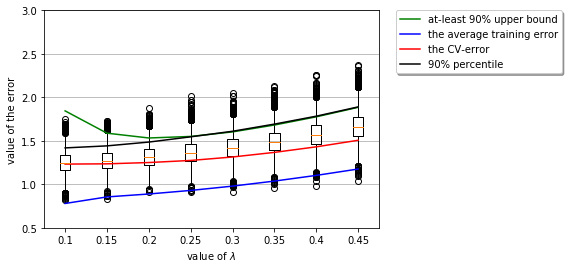

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


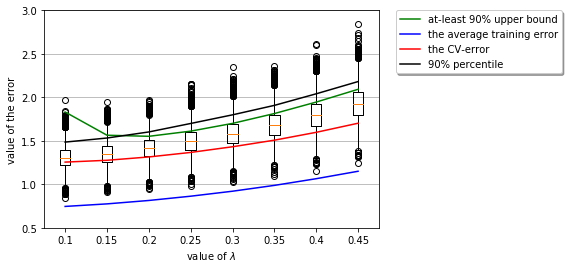

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


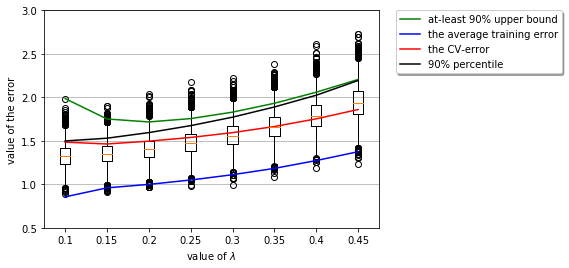

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


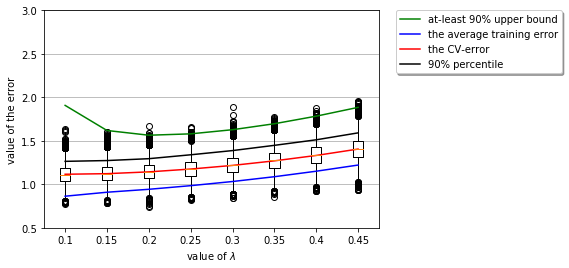

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


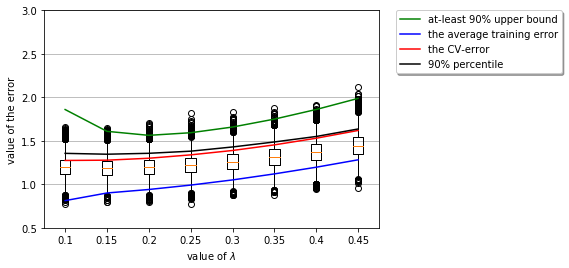

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


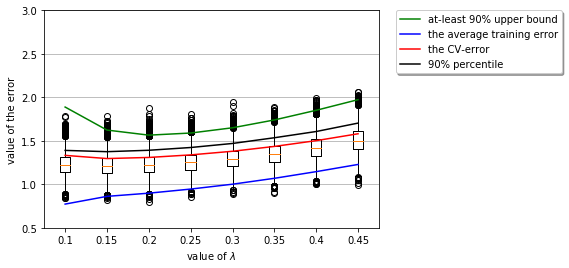

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


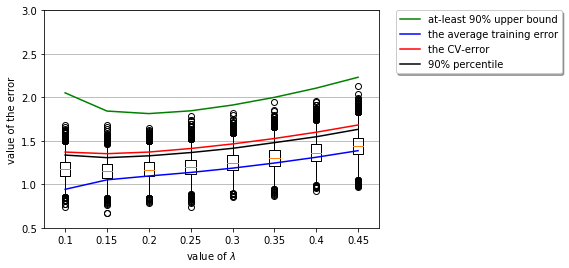

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


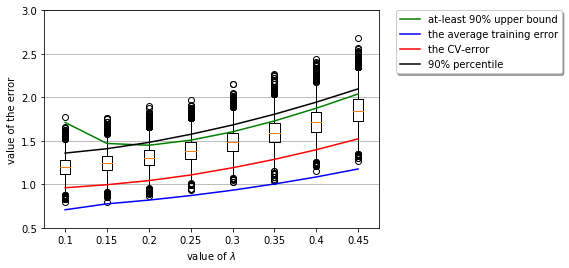

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


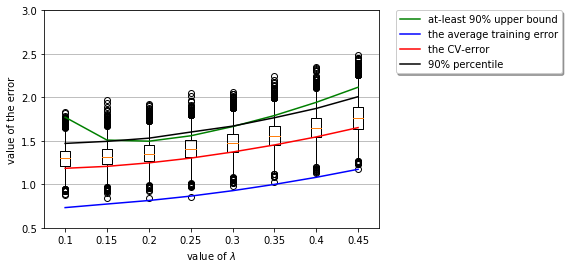

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


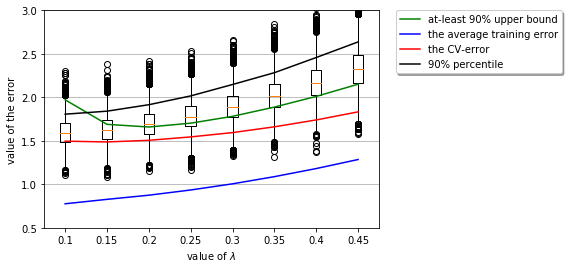

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


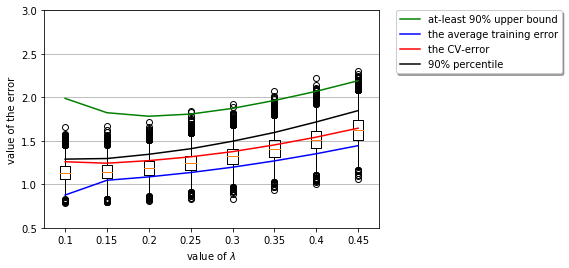

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


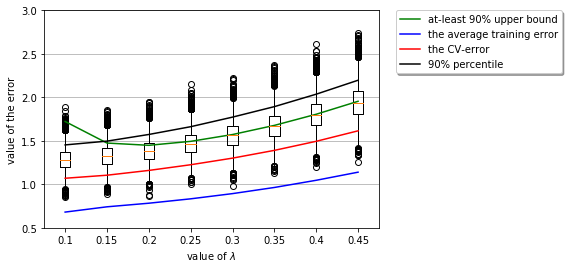

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


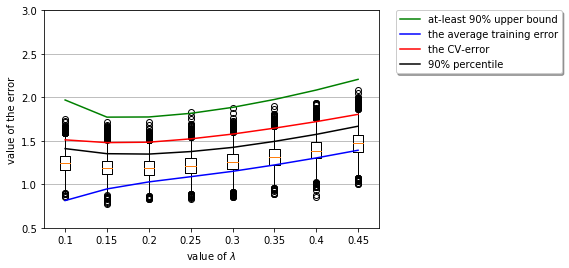

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


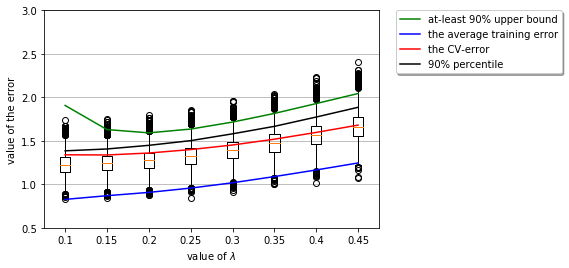

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


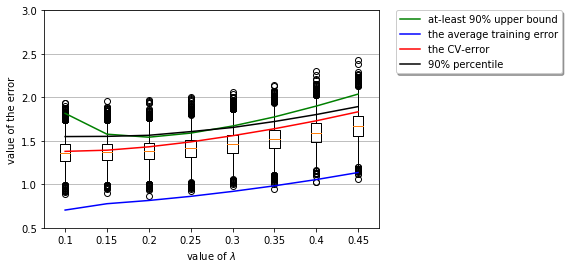

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


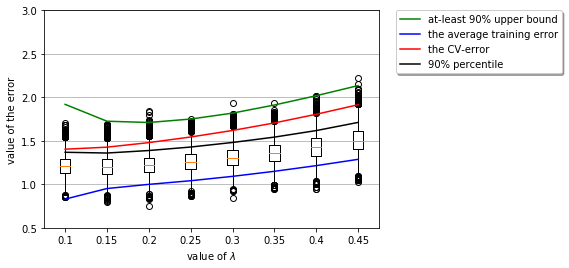

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


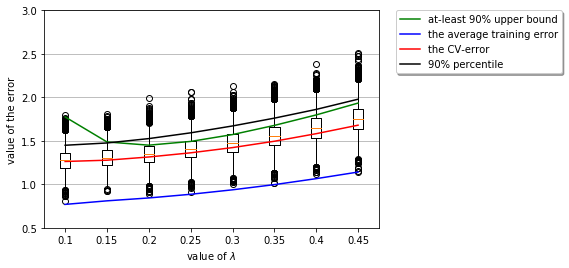

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


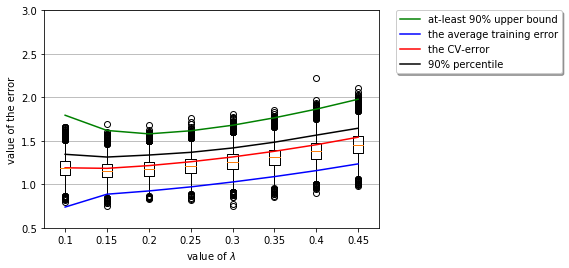

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


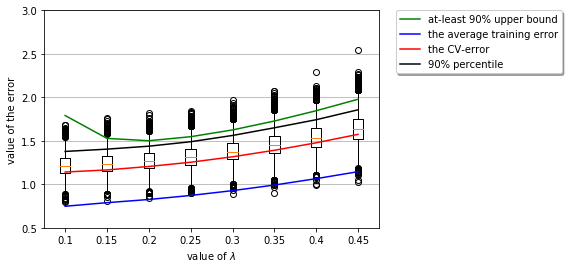

In [12]:
## average test error bounds for the lasso
## total sample size : 200

n2 = 100; test_size = n2;  #n2 is the size of each fold

# generate data

varpi = 0.1; K = 2

n_iter = 64; n_val = 10000; n_dim = 100; n_info = 5; cov_noise = 1

start = 0.1; end = 0.5; step = 0.05; alpha = np.arange(start, end, step)

end_seed = 100; step_seed = 5

lambda_cv_seq = list(); lambda_cub_seq = list()
selection_cv_seq = list();selection_cub_seq = list()

for i in range(0, end_seed, step_seed):
    
    np.random.seed(i)

    X12, Y12 = data_gen(n2, n_dim, n_info, cov_noise)

    X22, Y22 = data_gen(n2, n_dim, n_info, cov_noise)


    # training the model
    error_matrix_2, upper_array_2, train_array_2, test_array_2, perc_array_2,lambda_cv, lambda_cub = error_bounds(X12, Y12, X22, Y22, test_size, varpi, 
                                                                              n_iter, n_val, n_dim, n_info, cov_noise, start, end, step)
    # plot the figure
    error_plot_100(alpha, error_matrix_2, upper_array_2, train_array_2, test_array_2, perc_array_2, 
           "error_bound_plot_200.pdf")


## Step 3: repeated simulation of the upper bounds for $n = 400$.

We repeat the $n=400$ simulation 20 times using different random seeds. All the plots are attached after the code.


Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


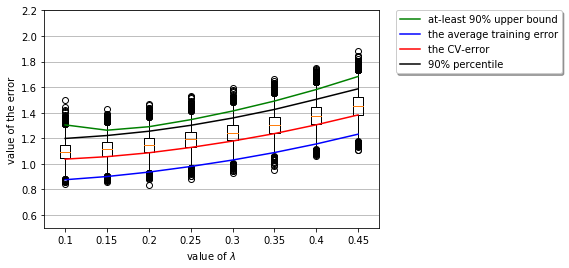

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


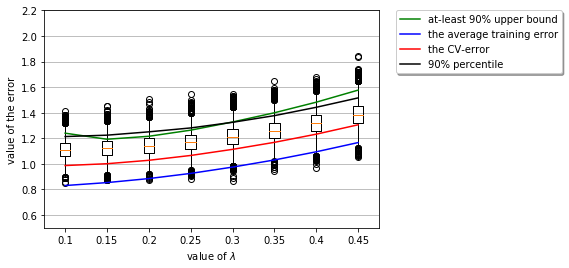

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


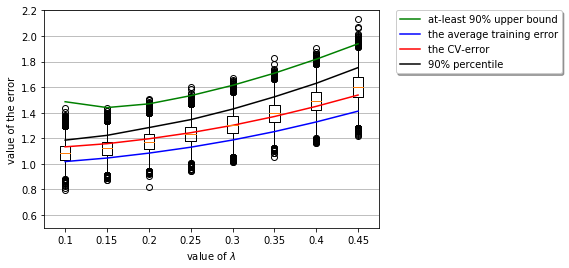

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


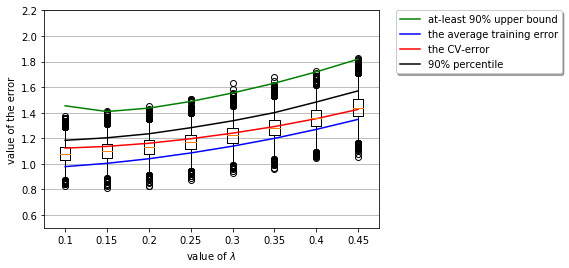

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


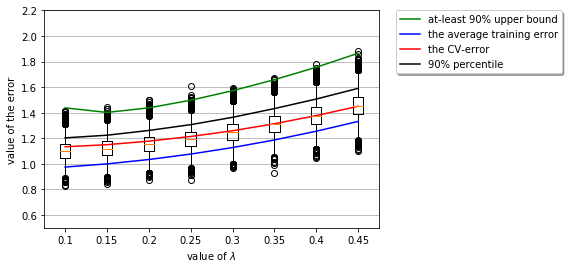

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


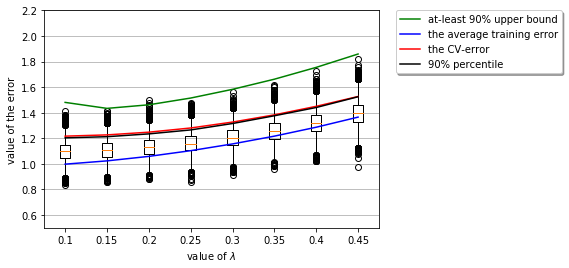

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


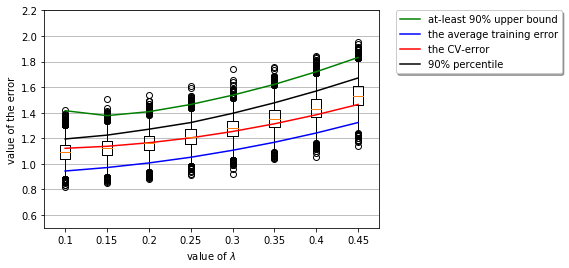

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


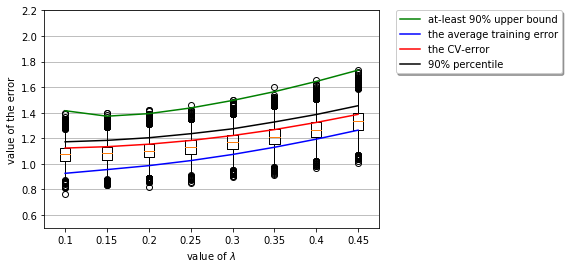

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


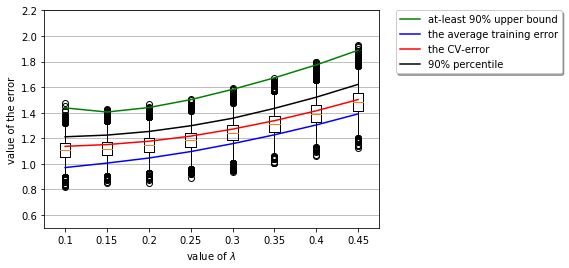

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


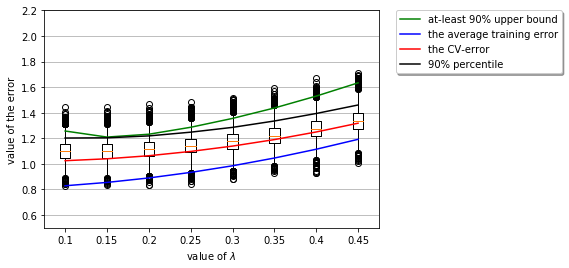

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


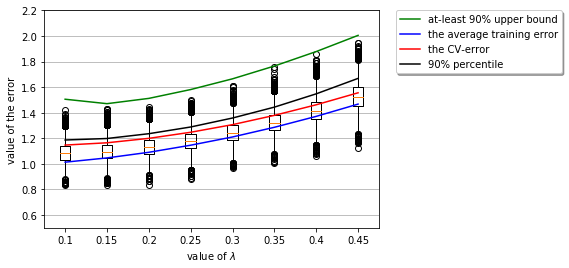

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


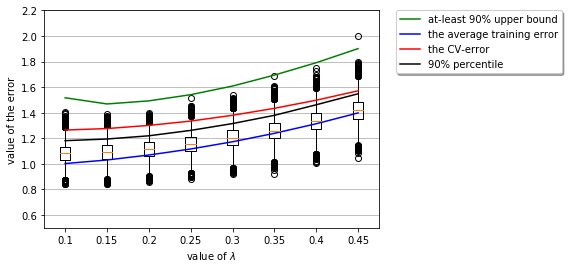

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


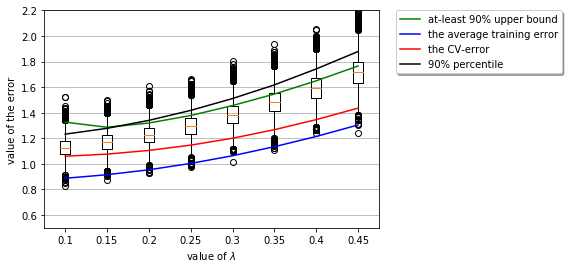

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


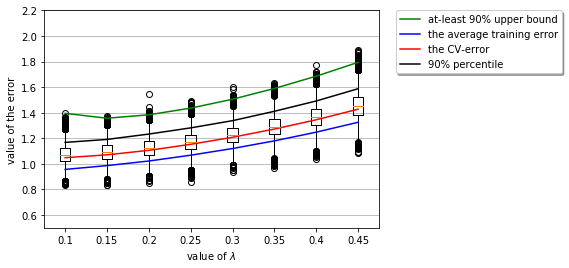

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


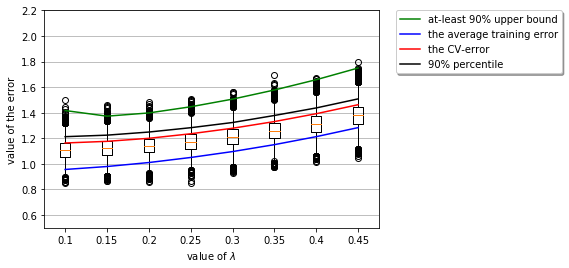

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


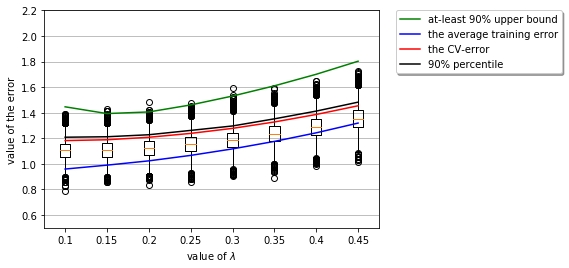

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


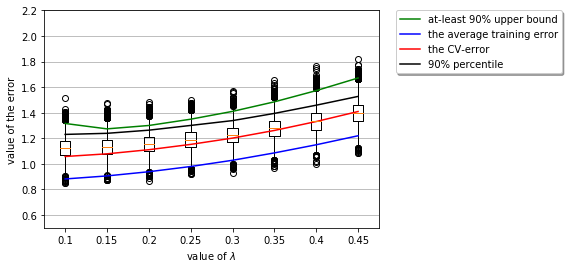

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


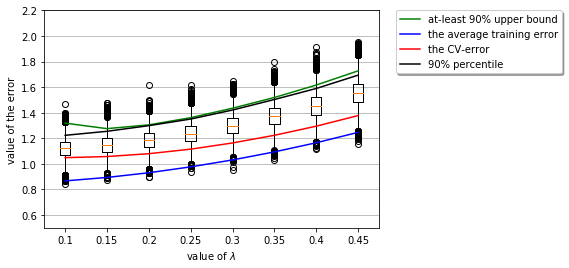

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


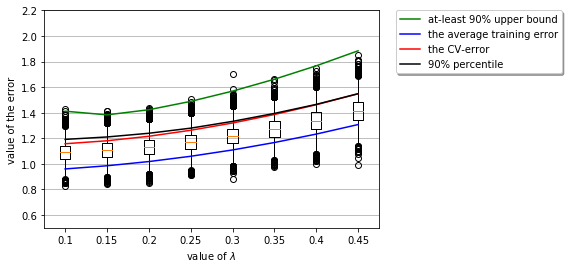

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


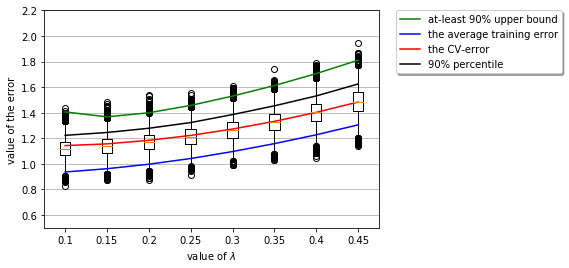

In [13]:
## average test error bounds for the lasso
## total sample size : 400

n5 = 200; test_size_5 = n5; np.random.seed(50) #n4 is the size of each fold

# generate data

lambda_cv_seq_5 = list(); lambda_cub_seq_5 = list()
selection_cv_seq_5 = list();selection_cub_seq_5 = list()

for i in range(0, end_seed, step_seed):
    
    np.random.seed(i)

    X15, Y15 = data_gen(n5, n_dim, n_info, cov_noise)

    X25, Y25 = data_gen(n5, n_dim, n_info, cov_noise)

    # training the model
    
    error_matrix_5, upper_array_5, train_array_5, test_array_5, perc_array_5, lambda_cv_5, lambda_cub_5 = error_bounds(X15, Y15, X25, Y25, test_size_5, varpi, 
                                                                              n_iter, n_val, n_dim, n_info, cov_noise, start, end, step)
    # plot the figure
    error_plot_200(alpha, error_matrix_5, upper_array_5, train_array_5, test_array_5, perc_array_5, 
           "error_bound_plot_400.pdf")


## Step 4 : repeated simulation of the upper bounds for $n = 100$.


Finally we repeat the $n=100$ simulation 20 times using different random seeds. All the plots are attached after the code.


Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


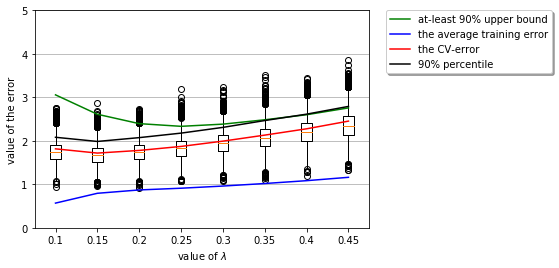

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


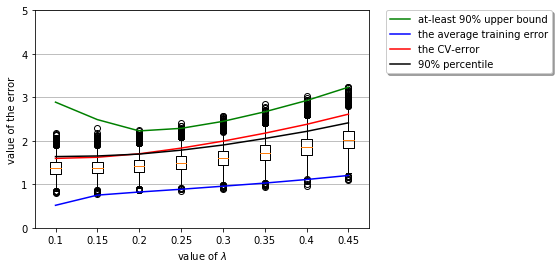

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


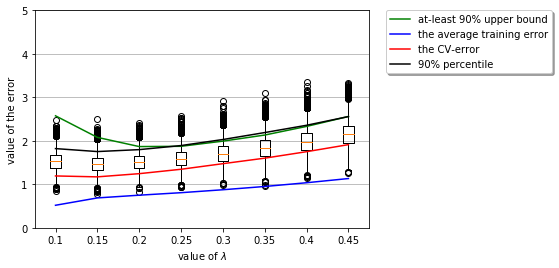

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


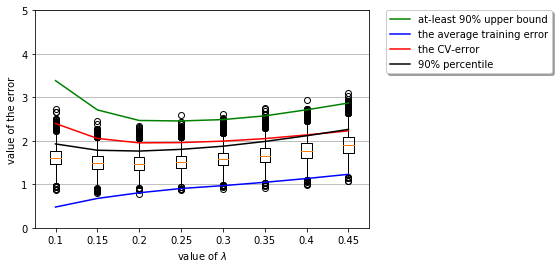

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


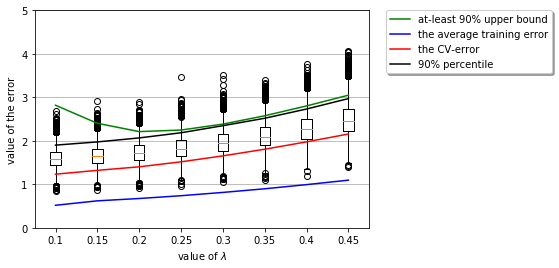

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


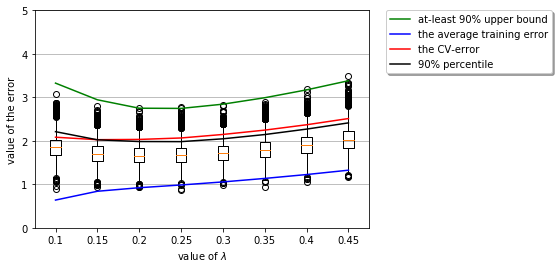

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


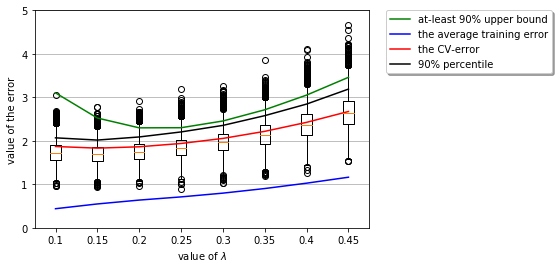

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


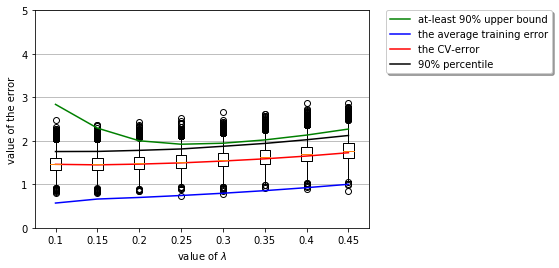

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


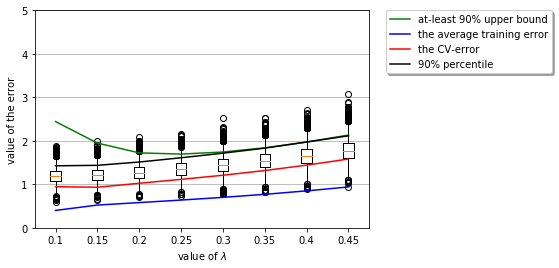

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


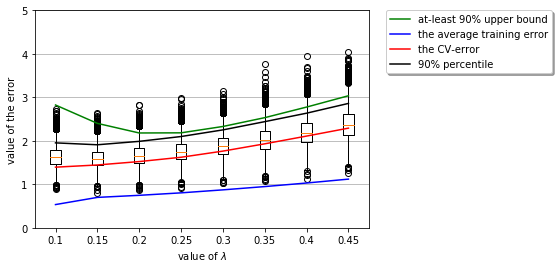

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


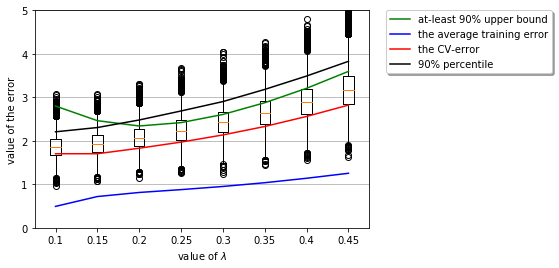

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


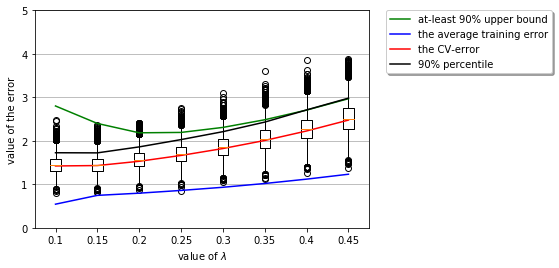

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


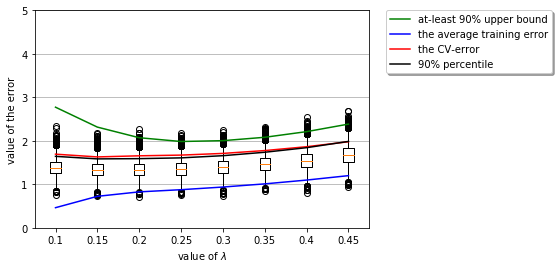

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


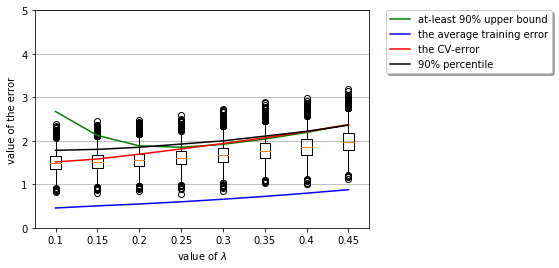

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


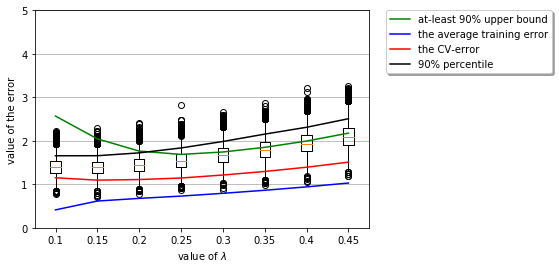

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


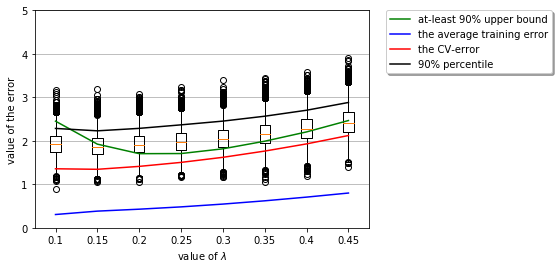

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


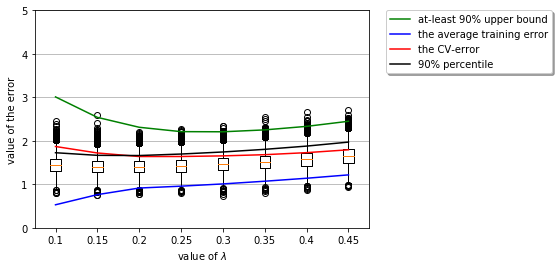

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


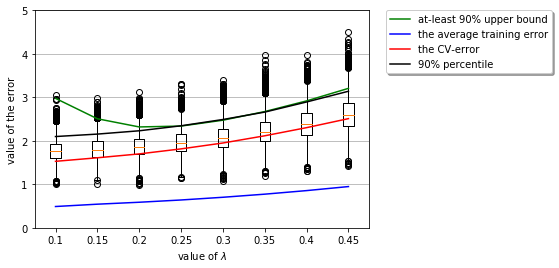

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


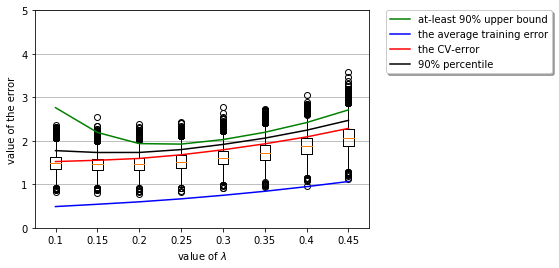

Model 1  computed out of  8
Model 2  computed out of  8
Model 3  computed out of  8
Model 4  computed out of  8
Model 5  computed out of  8
Model 6  computed out of  8
Model 7  computed out of  8
Model 8  computed out of  8


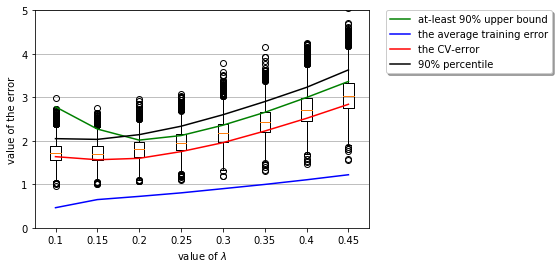

In [14]:
## average test error bounds for the lasso
## total sample size : 100

n3 = 50; test_size_3 = n3; np.random.seed(50) #n3 is the size of each fold

# generate data

lambda_cv_seq_3 = list(); lambda_cub_seq_3 = list()
selection_cv_seq_3 = list();selection_cub_seq_3 = list()

for i in range(0, end_seed, step_seed):
    
    np.random.seed(i)

    X13, Y13 = data_gen(n3, n_dim, n_info, cov_noise)

    X23, Y23 = data_gen(n3, n_dim, n_info, cov_noise)

    # training the model
    
    error_matrix_3, upper_array_3, train_array_3, test_array_3, perc_array_3, lambda_cv_3, lambda_cub_3 = error_bounds(X13, Y13, X23, Y23, test_size_3, varpi, 
                                                                              n_iter, n_val, n_dim, n_info, cov_noise, start, end, step)
    # plot the figure
    error_plot_50(alpha, error_matrix_3, upper_array_3, train_array_3, test_array_3, perc_array_3, 
               "error_bound_plot_100.pdf")